In [1]:
# Getting imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
# Importing torch
import torch
import torch.nn.functional as F
import torch.nn as nn

plt.style.use('ggplot')
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Load dataset
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
print(X_scaled.shape)
print(y.shape)
len(y==0)

(150, 4)
(150,)


150

In [4]:
# Splitting into train and test
count_dict = Counter(y)
print(count_dict)
train_size = {}
for key, value in count_dict.items():
    train_size[key] = int(value*0.8)
print('train_size', train_size)
train_X, train_y = [], []
test_X, test_y = [], []
for data, label in zip(X_scaled, y):
    if train_size[label] >0:
        train_X.append(data)
        train_y.append(label)
        train_size[label] = train_size[label]-1
    else:
        test_X.append(data)
        test_y.append(label)
X_train, y_train = np.array(train_X), np.array(train_y)
X_test, y_test = np.array(test_X), np.array(test_y)

Counter({0: 50, 1: 50, 2: 50})
train_size {0: 40, 1: 40, 2: 40}


In [5]:
print('Train shape', X_train.shape, y_train.shape)
print('Test shape', X_test.shape, y_test.shape)

Train shape (120, 4) (120,)
Test shape (30, 4) (30,)


In [6]:
# NOTE: Setting hyper-parameters
input_size = X_train.shape[1] # 28x28
hidden_size = [32,64,128,256,512,1024] 
num_classes = 3
num_epochs = 15
batch_size = 32
learning_rate = 0.001 

In [7]:
# Defining the dataloader
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train, dtype=torch.long)),
                                            batch_size=batch_size, 
                                            shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_test), torch.tensor(y_test, dtype=torch.long)),
                                           batch_size=batch_size, 
                                           shuffle=False)

In [8]:
# NOTE: Neural Model
class singleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(singleMLP, self).__init__()
        self.input_dim = input_dim
        self.l1 = nn.Linear(input_dim, hidden_dim) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_dim, num_classes)   
    def forward(self, x):
            out = self.l1(x)
            out = self.relu(out)
            out = self.l2(out)
            return out

In [9]:
# Defining the device
device = torch.device('cpu')

In [10]:
# Creating the model
model = singleMLP(input_size, hidden_size[0], num_classes).to(device)

In [11]:
# Defining the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# Defining the training loop
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(features.float())
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 1 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step[{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/15], Step[1/4], Loss: 1.1040
Epoch [1/15], Step[2/4], Loss: 1.0940
Epoch [1/15], Step[3/4], Loss: 1.0726
Epoch [1/15], Step[4/4], Loss: 1.0877
Epoch [2/15], Step[1/4], Loss: 1.0776
Epoch [2/15], Step[2/4], Loss: 1.0779
Epoch [2/15], Step[3/4], Loss: 1.0196
Epoch [2/15], Step[4/4], Loss: 1.0725
Epoch [3/15], Step[1/4], Loss: 1.0272
Epoch [3/15], Step[2/4], Loss: 1.0568
Epoch [3/15], Step[3/4], Loss: 1.0093
Epoch [3/15], Step[4/4], Loss: 1.0404
Epoch [4/15], Step[1/4], Loss: 0.9857
Epoch [4/15], Step[2/4], Loss: 1.0155
Epoch [4/15], Step[3/4], Loss: 1.0156
Epoch [4/15], Step[4/4], Loss: 1.0064
Epoch [5/15], Step[1/4], Loss: 0.9808
Epoch [5/15], Step[2/4], Loss: 0.9648
Epoch [5/15], Step[3/4], Loss: 0.9945
Epoch [5/15], Step[4/4], Loss: 0.9717
Epoch [6/15], Step[1/4], Loss: 0.9047
Epoch [6/15], Step[2/4], Loss: 0.9870
Epoch [6/15], Step[3/4], Loss: 0.9724
Epoch [6/15], Step[4/4], Loss: 0.9360
Epoch [7/15], Step[1/4], Loss: 0.8885
Epoch [7/15], Step[2/4], Loss: 0.9514
Epoch [7/15]

In [13]:
# Testing the model
with torch.no_grad():
    true_lables = []
    predicted_labels = []
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features.float())
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted)
        true_lables.extend(labels)
    accuracy = accuracy_score(true_lables, predicted_labels)*100
    print(f'Accuracy of the network on the 30 test features: {accuracy} %')
    print(classification_report(true_lables, predicted_labels)) 

Accuracy of the network on the 30 test features: 93.33333333333333 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.80      0.89        10
           2       0.83      1.00      0.91        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



In [14]:
# NOTE; Experimenting with different values of hidden layers
accuracies = []
for hidden_size_val in hidden_size:
    print('Experimenting with hidden size value', hidden_size_val)
    # Creating the model
    model = singleMLP(input_size, hidden_size_val, num_classes).to(device)
    # Defining the loss and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Defining the training loop
    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        for i, (features, labels) in enumerate(train_loader):  
            # origin shape: [100, 1, 28, 28]
            # resized: [100, 784]
            features = features.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(features.float())
            loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i+1) % 200 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step[{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    # Testing the model
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        true_lables = []
        predicted_labels = []
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features.float())
            # max returns (value ,index)
            _, predicted = torch.max(outputs.data, 1)
            predicted_labels.extend(predicted)
            true_lables.extend(labels)
        accuracy = accuracy_score(true_lables, predicted_labels)*100
        accuracies.append(accuracy)
        print(f'Accuracy of the network on the 30 test features: {accuracy} %')
        print(classification_report(true_lables, predicted_labels)) 

Experimenting with hidden size value 32
Accuracy of the network on the 30 test features: 83.33333333333334 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.78      0.70      0.74        10
           2       0.73      0.80      0.76        10

    accuracy                           0.83        30
   macro avg       0.84      0.83      0.83        30
weighted avg       0.84      0.83      0.83        30

Experimenting with hidden size value 64
Accuracy of the network on the 30 test features: 90.0 %
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.70      0.82        10
           2       0.83      1.00      0.91        10

    accuracy                           0.90        30
   macro avg       0.91      0.90      0.90        30
weighted avg       0.91      0.90      0.90        30

Experimenting with hidden size va

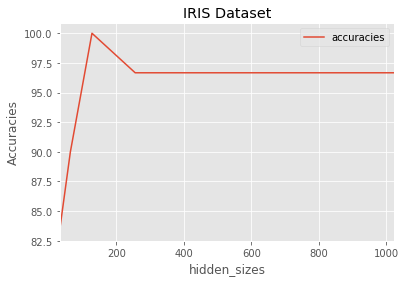

In [19]:
# Plotting the trend of accuracy vs hidden_dim
accuracy_df = pd.DataFrame()
accuracy_df['hidden_sizes'] = hidden_size
accuracy_df['accuracies'] = accuracies
accuracy_df.plot(x="hidden_sizes", y="accuracies", kind="line")
plt.title('IRIS Dataset')
plt.ylabel('Accuracies')
plt.show()